# Data Deep Dive: Investigating the Ground Truth Masks

### Objective
Before proceeding with more complex models, we need to build a stronger intuition for our ground truth data. This notebook serves as a visual audit to answer a key question:

*   **Do any of the MRI slices in our eligible dataset contain two distinct ovaries?**

Understanding this is crucial. If we only ever see one ovary per slice, the model is learning to identify a single object. If two are sometimes present, the problem is slightly different, and we need to be aware of it.

### Methodology
We will load our clean manifest of 56 eligible patients. We will then iterate through a large number of slices from the **entire dataset (both training and validation portions)** and plot a grid of the ground truth masks. Each mask will be labeled with its source `patient_id` and `slice_index` to ensure we are seeing a diverse sample.

Loading manifest from ../data/d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Total eligible patients with ovaries: 56
Displaying one sample slice from the first 36 unique patients...


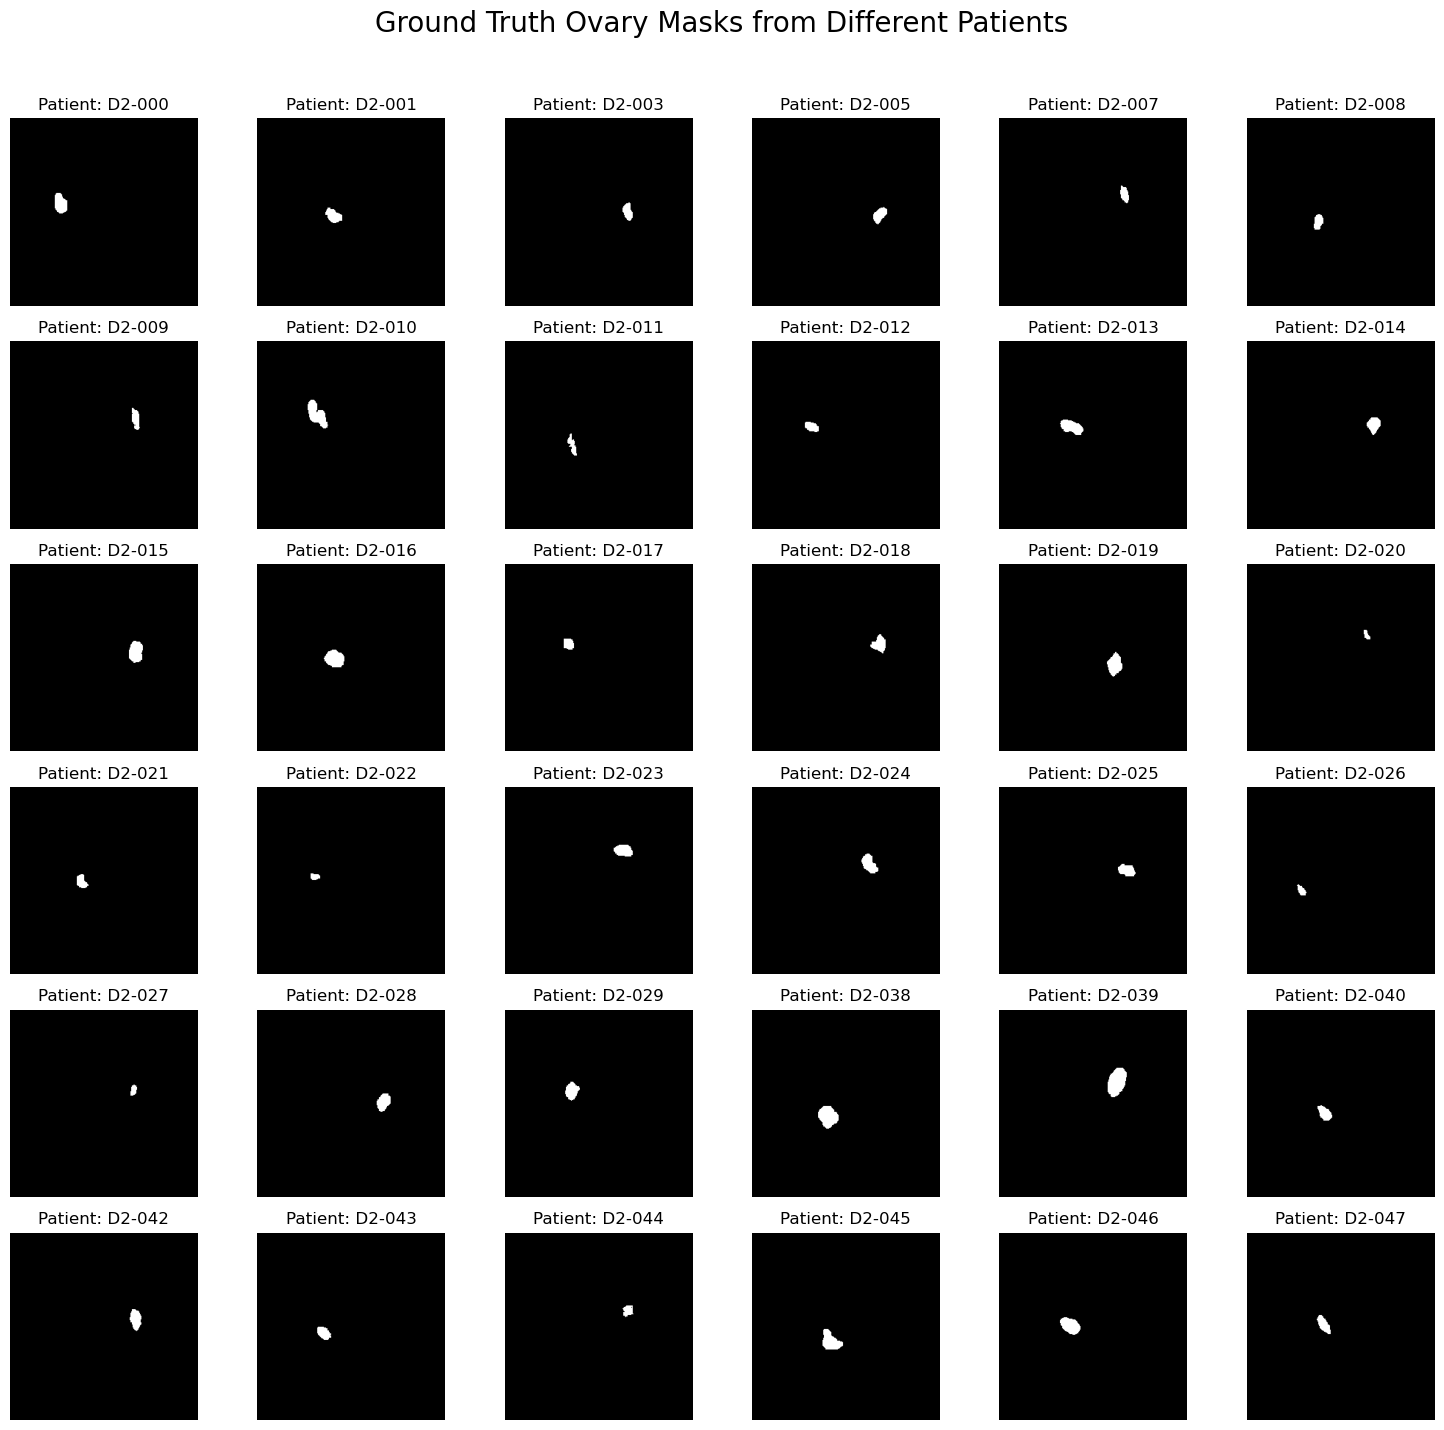

In [ ]:
# --- Imports and Setup ---
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sys
import numpy as np

# Add project root to path
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import UterusDataset

# --- Configuration ---
manifest_path = '../data/d2_manifest_t2fs_ovary_eligible.csv'
image_size = 256
num_patients_to_show = 36 # How many unique patients to visualize

# --- Load the FULL eligible dataset ---
full_dataset = UterusDataset(manifest_path=manifest_path, image_size=image_size, augment=False)

print(f"Total eligible patients with ovaries: {len(full_dataset.manifest)}")
print(f"Displaying one sample slice from the first {num_patients_to_show} unique patients...")

# --- Visualize a Grid of Masks from DIFFERENT Patients ---
fig, axes = plt.subplots(6, 6, figsize=(15, 15))
fig.suptitle("Ground Truth Ovary Masks from Different Patients", fontsize=20)
axes = axes.flatten()

# Get a list of unique patient IDs from the manifest
unique_patient_ids = full_dataset.manifest['patient_id'].unique()

# Keep track of which patients we've already plotted
plotted_patients = set()
slice_counter = 0
plot_idx = 0

# Iterate through the entire slice map to find one slice per patient
while plot_idx < num_patients_to_show and slice_counter < len(full_dataset.slice_map):
    slice_info = full_dataset.slice_map[slice_counter]
    patient_id = full_dataset.manifest.iloc[slice_info['patient_index']]['patient_id']
    
    # If we haven't plotted this patient yet, plot their mask
    if patient_id not in plotted_patients:
        _, mask = full_dataset[slice_counter]
        mask_np = mask.cpu().squeeze().numpy()
        
        ax = axes[plot_idx]
        ax.imshow(mask_np, cmap='gray')
        ax.set_title(f"Patient: {patient_id}")
        ax.axis('off')
        
        plotted_patients.add(patient_id)
        plot_idx += 1
        
    slice_counter += 1


# Hide any unused subplots
for j in range(plot_idx, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()


# Data Deep Dive: Analysis of Ground Truth Masks

### Objective
This notebook was created to investigate a key characteristic of our dataset. We wanted to confirm whether the ground truth masks typically contain one or two ovaries per slice, as this fundamentally impacts our modeling strategy.

### Methodology
We visualized 36 ground truth ovary masks, sampling one representative slice from 36 unique patients across the entire eligible dataset (both training and validation sets). This ensures a broad and unbiased view of the data's structure.

### Key Finding
The visual audit confirms that the ground truth data for this task almost exclusively consists of **single-object segmentation masks**. In our extensive sample, no slices containing two distinct, separate ovaries were observed.

### Interpretation and Implications
1.  **Confirmation of Task Difficulty**: This finding highlights the difficulty of the task. The target object is often singular, small, and variable in shape, making it a classic "needle in a haystack" problem for the model.
2.  **Justification for the Paper's Pipeline**: This observation strongly supports the two-stage pipeline used in the "RAovSeg" paper. The first stage (`ResClass`) is critical for identifying the few slices that contain *any* ovary, while the second stage (`AttUSeg`, which we are building) can focus on the simpler task of segmenting the single object it is given.
3.  **Confidence to Proceed**: We can now be confident that our current experimental setup, which trains a model to segment a single object per image, is the correct approach. We do not need to implement logic for separating multiple instances at this stage.

This deep dive validates our direction and provides a solid foundation for the next experiments.